In [32]:
import sys
sys.path.append('../..')
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from unknown.loaders.test_split import SpeciesBalancedTestTrainSplitter
from unknown.models.zoo import get_gs_params, get_model
from unknown.utils.helpers import load_configs_given_paths
from unknown.utils.paths import ROOT_DIR
from unknown.loaders.cache_loader import T2Iterator
from unknown.config.trials import trials
from unknown.config.config import UnknownConfigLoader
cfg = UnknownConfigLoader()

## Please note: to re-run this notebook, you must have already run tier1. 

In [26]:
# Use this constant to configure the path to the config file. This is the same one you would put in CLOSED_CONFIG, OPEN_CONFIG (see readme for details)

CLOSED_CONFIG_PATH = "configs/old_configs/paper_redo/closed/fold1/config.py" 
OPEN_CONFIG_PATH = "configs/old_configs/paper_redo/open/fold1/config.py" 

In [28]:
def make_absolute(fpath):
  if fpath is None:
    raise ValueError(f'fpath cannot be None')
  if not os.path.exists(fpath) and not os.path.isabs(fpath):
    fpath = os.path.join(ROOT_DIR, fpath)
  if not os.path.exists(fpath):
    raise ValueError(f"Could not load module for ({fpath}).\nAre you sure that file exists?")
  return fpath

CLOSED_CONFIG_PATH = make_absolute(CLOSED_CONFIG_PATH)
OPEN_CONFIG_PATH = make_absolute(OPEN_CONFIG_PATH)

In [33]:

# constants
trial_name = 'T1'
species_seed = 0
# load data
trial = trials[trial_name]
t1_closed_config, t1_open_config = load_configs_given_paths(CLOSED_CONFIG_PATH, OPEN_CONFIG_PATH)
splitter = SpeciesBalancedTestTrainSplitter(t1_closed_config, t1_open_config, random_seed=cfg.SEED)
t2_iter = T2Iterator(trial, splitter, fold=t1_closed_config.FOLD, species_seed=species_seed, use_val=True)

x_train, y_train, id_train = t2_iter.load('train')
x_valid, y_valid, id_valid = t2_iter.load('valid')

In [34]:
n_list = list(range(2, 10, 1))
metrics = {
    'accuracy': [],
    'f1': [],
    'precision': [],
    'recall': [],
    'n': n_list
}

In [37]:
from unknown.models.t3.garb import BinaryGaussianArbitrationClassifier
import numpy as np
import pandas as pd


for n in n_list:
    best_params = {
        'unsure_lower_bound': 0.3,
        'unsure_upper_bound': 0.9,
        'n_components': n,
        'unknown_frac': 0.1
    }
    # train model
    clf = BinaryGaussianArbitrationClassifier(
                    n_init=10, thresholding_method='percentile', 
                    random_state=cfg.SEED, **best_params)
    clf.fit(x_train, y_train)

    # predict
    df = pd.DataFrame(x_valid)
    df['probas'] = np.apply_along_axis(lambda row: sum(row)/len(row), axis=1, arr=x_valid)
    df['preds'] = np.apply_along_axis(lambda row: int((sum(row)/len(row)) > 0.5), axis=1, arr=x_valid)
    df['y'] = y_valid

    df_unsure = df[(df.probas <= clf.unsure_upper_bound) & (df.probas >= clf.unsure_lower_bound)]
    df_unsure_unknown = df_unsure[df_unsure.y == 1]
    df_unsure_known = df_unsure[df_unsure.y == 0]

    x_unsure = df_unsure.drop(columns=['probas', 'preds', 'y']).to_numpy()
    x_unsure_unknown = df_unsure_unknown.drop(columns=['probas', 'preds', 'y']).to_numpy()
    x_unsure_known = df_unsure_known.drop(columns=['probas', 'preds', 'y']).to_numpy()

    scores = clf.gm.score_samples(x_unsure)
    preds_unsure = (scores < clf.density_threshold)*1

    df.iloc[df_unsure.index, df.columns.get_loc("preds")] = preds_unsure

    preds = df.preds.to_numpy()
    
    accuracy = accuracy_score(y_valid, preds)
    # print(f"Valid Accuracy: {accuracy}")
    metrics['accuracy'].append(accuracy)

    f = f1_score(y_valid, preds)
    # print(f"Valid F1: {f}")
    metrics['f1'].append(f)

    prec = precision_score(y_valid, preds)
    # print(f"Valid Precision: {prec}")
    metrics['precision'].append(prec)

    rec = recall_score(y_valid, preds)
    # print(f"Valid Recall: {rec}")
    metrics['recall'].append(rec)
print("Complete")

Complete


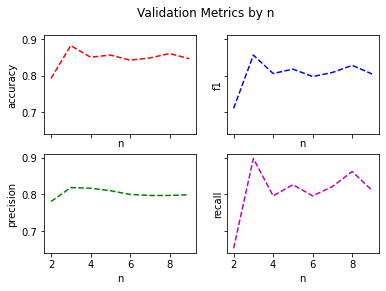

In [39]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle("Validation Metrics by n")

# Accuracy
ax1.plot('n', 'accuracy', 'r--', data=metrics)
ax1.set_xlabel('n')
ax1.set_ylabel('accuracy')

# F1
ax2.plot('n', 'f1', 'b--', data=metrics)
ax2.set_xlabel('n')
ax2.set_ylabel('f1')

# Precision
ax3.plot('n', 'precision', 'g--', data=metrics)
ax3.set_xlabel('n')
ax3.set_ylabel('precision')

# Recall
ax4.plot('n', 'recall', 'm--', data=metrics)
ax4.set_xlabel('n')
ax4.set_ylabel('recall')


plt.show()
